In [280]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import json
from dataloader import Twitch
import tensorflow as tf
from spektral.layers import GCNConv
from tensorflow.keras.layers import Dropout, Dense, Input
from utils import *
from sklearn.model_selection import train_test_split
from spektral.layers import GCNConv, GATConv
from spektral.models.gcn import GCN
from spektral.transforms import LayerPreprocess, AdjToSpTensor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from spektral.datasets.citation import Citation



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [278]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(self, n_labels=2, hidden_channels=64, dropout_rate=0.2,
                 prior_weights=None, fisher_matrix=None, lambda_=0.1):
        super(GNNNodeClassifier, self).__init__()
        self.conv1 = GCNConv(hidden_channels, activation='relu')
        self.conv2 = GCNConv(hidden_channels, activation='relu')
        self.conv3 = GCNConv(hidden_channels, activation='relu')
        self.fn1 = Dense(hidden_channels, activation='relu')
        self.fn2 = Dense(n_labels)
        self.dropout_rate = dropout_rate
    
    def call(self, inputs):
        x, adj = inputs
        
        x = self.conv1([x, adj])
        x = self.conv2([x, adj])
        x = self.conv3([x, adj])
        x = Dropout(self.dropout_rate)(x)
        x = self.fn1(x)
        x = Dropout(self.dropout_rate)(x)
        x = self.fn2(x)

        return x

In [349]:
class BasicGCN(tf.keras.Model):
    def __init__(self, n_labels=2, hidden_channels=64):
        super(BasicGCN, self).__init__()
        self.conv1 = GCNConv(hidden_channels, activation='relu')
        self.conv2 = GCNConv(n_labels)
    
    def call(self, inputs):
        x, adj = inputs
        
        x = self.conv1([x, adj])
        x = self.conv2([x, adj])
        
        return x

In [113]:
dataset = Twitch("ES", normalize_x=True, transforms=[LayerPreprocess(GCNConv), AdjToSpTensor()])
graph = dataset[0]
x, adj, y = graph.x, graph.a, graph.y
mask_tr, mask_va, mask_te = dataset.mask_tr, dataset.mask_va, dataset.mask_te

In [342]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

def train_step(inputs, labels, mask, model, optimizer, loss_fn, with_ewc=False):
  with tf.GradientTape() as tape:
    pred = model(inputs)
    loss = loss_fn(labels[mask], pred[mask])

    if with_ewc:
      loss += model.penalty_loss()
      
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  return loss

def masked_binary_loss(mask):
  def custom_loss(y_pred, y_true):
    return BinaryCrossentropy()(y_pred[mask], y_true[mask])
  
  return custom_loss

Accuracy: 0.5826315789473684
% of 1s:  0.8063157894736842


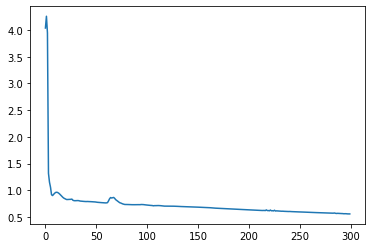

In [306]:
lr = 1e-2
epochs = 300

(x, adj, y), (mask_tr, _, mask_te) = load_task("DE", path="./data/twitch/")

model_A = BasicGCN(n_labels=2, hidden_channels=64)
loss_fn = BinaryCrossentropy()
optim = Adam(learning_rate=lr)

losses = []

for i in range(epochs):
    losses.append(train_step([x, adj], y, mask_tr, model_A, optim, loss_fn))

plt.plot(losses)

pred = model_A([x, adj]).numpy().argmax(axis=1)
acc = (pred[mask_te] == y[mask_te].argmax(axis=1)).mean()
print(f"Accuracy: {acc}")
print("% of 1s: ", pred[mask_te].sum() / len(pred[mask_te]))

In [90]:
def apx_fisher(model, inputs):
  """ Approximate the fisher matrices of the model parameters """
  fisher_matrices = {p: tf.zeros_like(v.value()) for p,v in enumerate(model.trainable_variables)}

  with tf.GradientTape() as tape:
    pred = model(inputs)

    # get loglikelihood of predictions
    loglike = tf.nn.log_softmax(pred)
  
  # compute gradient wrt loglikelihood
  loglike_grads = tape.gradient(loglike, model.trainable_variables)

  # approximate i-th Fisher matrix with gradients squared
  for i,g in enumerate(loglike_grads):
    fisher_matrices[i] += tf.reduce_mean(g**2, axis=0)
  
  return fisher_matrices

In [120]:
fisher_A = apx_fisher(model, [x, adj])

In [130]:
weights_A = model_A.get_weights()
model_B = GNNNodeClassifier(prior_weights=weights_A, fisher_matrix=fisher_A)
model_B([x, adj])   # one call to initialize weights
model_B.set_weights(model_A.get_weights())  # set to previous weights

In [376]:
def load_task(dataset="Twitch", language=None, path="./twitch", feature_dim=None):
  if dataset == "Twitch":
    dataset = Twitch(language, path=path, feature_dim=feature_dim, normalize_x=True,
                    transforms=[LayerPreprocess(GCNConv), AdjToSpTensor()])
  elif dataset == "Git":
    dataset = Git(normalize_x=True, transforms=[LayerPreprocess(GCNConv), AdjToSpTensor()])

  graph = dataset[0]
  x, adj, y = graph.x, graph.a, graph.y

  # the mask are computed randomly inside the dataloader
  mask_tr, mask_va, mask_te = dataset.mask_tr, dataset.mask_va, dataset.mask_te

  return (x, adj, y), (mask_tr, mask_va, mask_te)

In [197]:
(x_A, adj_A, y_A), (mask_tr_A, mask_va_A, mask_te_A) = load_task(language="DE", path="./data/twitch/")
(x_B, adj_B, y_B), (mask_tr_B, mask_va_B, mask_te_B) = load_task(language="FR", path="./data/twitch/")

Accuracy: 0.6312977099236641


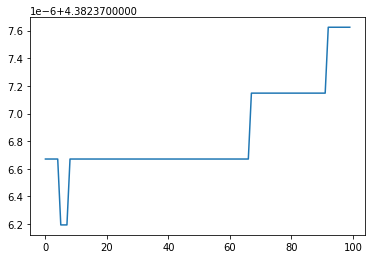

In [196]:
losses = []

for i in range(epochs):
    losses.append(train_step(inputs=[x_B, adj_B], labels=y_B, mask=mask_tr_B,
                             model=model_B, optimizer=optim, loss_fn=loss_fn, with_ewc=True))

plt.plot(losses)

pred = model_B([x_B, adj_B]).numpy().argmax(axis=1)
acc = (pred[mask_te_B] == y_B[mask_te_B].argmax(axis=1)).mean()
print(f"Accuracy: {acc}")

In [198]:
pred = model_B([x_A, adj_A]).numpy().argmax(axis=1)
acc = (pred[mask_te_A] == y_A[mask_te_A].argmax(axis=1)).mean()
print(f"Accuracy: {acc}")

Accuracy: 0.3957894736842105


In [377]:
from os import listdir

class ModelEval():
    def __init__(self, dataset="Twitch", path="./data/twitch/", feature_dim=100):
        super(ModelEval, self).__init__()

        if dataset == "Twitch":
            languages = list(filter(lambda x: "txt" not in x, listdir(path)))

            self.tasks = {}

            for lang in languages:
                data, masks = load_task(dataset="Twitch", language=lang, path=path, feature_dim=feature_dim)
                self.tasks[lang] = {"data": data, "masks": masks}
        elif dataset == "Git":
            data, masks = load_task(dataset="Git")
            self.tasks = {"data": data, "masks": masks}
    
    def train(self, language=None, epochs=20, cl=False, with_ewc=False, lr=0.01, lambda_=0.1, verbose=False):
        if language is not None:
            x, adj, y = self.tasks[language]["data"]
            mask_tr, _, _ = self.tasks[language]["masks"]
        else:
            x, adj, y = self.tasks["data"]
            mask_tr, _, _ = self.tasks["masks"]

        # initialize model
        if not cl:
            self.model = GNNNodeClassifier()
            self.optim = Adam(learning_rate=lr)

        loss_fn = CategoricalCrossentropy()
        
        for i in range(epochs):
            with tf.GradientTape() as tape:
                pred = self.model([x, adj])
                loss = loss_fn(y[mask_tr], pred[mask_tr])

                if cl and with_ewc:
                    loss += penalty_loss(self.fisher_matrix, self.model.get_weights(),
                                         self.prior_weights, lambda_=lambda_)
        
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optim.apply_gradients(zip(gradients, self.model.trainable_variables))

        self.prior_weights = self.model.get_weights()
        self.fisher_matrix = apx_fisher(self.model, [x, adj])
    
    def test(self, language):
        x, adj, y = self.tasks[language]["data"]
        _, _, mask_te = self.tasks[language]["masks"]

        pred = self.model([x, adj]).numpy().argmax(axis=1)
        acc = (pred[mask_te] == y[mask_te].argmax(axis=1)).mean()

        print(pred.sum() / len(pred))

        return acc

In [340]:
def penalty_loss(fisher_matrix, current_weights, prior_weights, lambda_=0.1):
    loss = 0

    for u, v, w in zip(fisher_matrix, current_weights, prior_weights):
        loss += tf.reduce_sum(u*tf.square(v-w))
    
    return 0.5 * lambda_ * loss

In [378]:
model_eval = ModelEval(dataset="Git", path="./data/git_web_ml/")
model_eval.train(epochs=10)

AttributeError: Exception encountered when calling layer "gcn_conv_318" (type GCNConv).

'tuple' object has no attribute 'rank'

Call arguments received:
  • inputs=['tf.Tensor(shape=(37700, 4004), dtype=float32)', "<37700x37700 sparse matrix of type '<class 'numpy.float64'>'\n\twith 578006 stored elements in Compressed Sparse Row format>"]
  • mask=None

In [344]:
model_eval = ModelEval()
model_eval.train("DE", epochs=200)
acc, pred, mask_te = model_eval.test("DE")
print(round(acc, 3))
print("number of 1s: ", pred.sum())

0.407
number of 1s:  594


In [362]:
model_eval = ModelEval()
model_eval.train("DE", epochs=100)
print("Accuracy on DE after training on DE: ", model_eval.test("DE"))

model_eval.train("RU", cl=True, with_ewc=False, lambda_=0.1, epochs=100)
print("Accuracy on RU after training on DE+FR w/o EWC: ", model_eval.test("RU"))
print("Accuracy on DE after training on DE+FR w/o EWC: ", model_eval.test("DE"))

Accuracy on DE after training on DE:  0.6042105263157894
Accuracy on RU after training on DE+FR w/o EWC:  0.7548460661345496
Accuracy on DE after training on DE+FR w/o EWC:  0.3957894736842105


In [364]:
model_eval = ModelEval()
model_eval.train("DE", epochs=50)
model_eval.train("RU", cl=True, with_ewc=True, lambda_=0.1, epochs=50)
print("Accuracy on FR after training on DE+FR w EWC: ", model_eval.test("DE"))
print("Accuracy on DE after training on DE+FR w EWC: ", model_eval.test("RU"))

1.0
Accuracy on FR after training on DE+FR w EWC:  0.6047368421052631
1.0
Accuracy on DE after training on DE+FR w EWC:  0.2451539338654504


In [251]:
model_eval = ModelEval()
model_eval.train("FR")
print("Accuracy on FR after training on FR w EWC: ", model_eval.test("RU"))

Accuracy on FR after training on FR w EWC:  0.7548460661345496


In [253]:
print("Accuracy on FR after training on DE+FR w EWC: ", model_eval.test("FR"))

Accuracy on FR after training on DE+FR w EWC:  0.6312977099236641


In [264]:
data, _ = load_task("DE", path="./data/twitch/")

In [269]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
pca.fit_transform(data[0]).shape

(9498, 100)

In [366]:
from spektral.datasets.graphsage import GraphSage
x, adj, y, mask_tr, mask_va, mask_te = GraphSage("ppi")

ConnectionError: HTTPConnectionPool(host='snap.stanford.edu', port=80): Max retries exceeded with url: /graphsage/ppi.zip (Caused by NewConnectionError("<urllib3.connection.HTTPConnection object at 0x000001F768E8C940>: Failed to establish a new connection: [WinError 10060] Impossibile stabilire la connessione. Risposta non corretta della parte connessa dopo l'intervallo di tempo oppure mancata risposta dall'host collegato"))

In [373]:
from dataloader import Git

data = Git(path="./data/git_web_ml/")

37700 37700


In [375]:
data[0]

Graph(n_nodes=37700, n_node_features=4004, n_edge_features=None, n_labels=2)